Here's a structured academic documentation template following your requirements:

---

# Multi-Criteria Smartphone Ranking Using ELECTRE-III Method

## Project Overview  
This study presents a multi-criteria decision analysis (MCDA) framework for smartphone evaluation using the ELECTRE-III outranking method. The implementation considers three distinct preference configurations to assess how different weighting strategies impact device rankings. The analysis leverages technical specifications from contemporary smartphones across five key criteria: processing power, memory capacity, camera performance, battery capacity, and physical weight.

## Methodological Framework  

### 1. ELECTRE-III Key Formulations  
The implementation follows these essential ELECTRE-III components:

#### Credibility Matrix Calculation:  
For each alternative pair (a, b):  

$
\sigma(a,b) = \prod_{j \in F(a,b)} \frac{1 - d_j(a,b)}{1 - C(a,b)}
$

where:  
- $C(a,b)$ = Concordance index  
- $d_j(a,b)$ = Discordance index for criterion $j$
- $F(a,b)$ = Set of criteria where $d_j(a,b) > C(a,b)$

#### Net Flow Score:  

$
\phi(a) = \sum_{b \neq a} \sigma(a,b) - \sum_{b \neq a} \sigma(b,a)
$

### 2. Configuration Pipeline  
For each preference scenario, the analysis executes these sequential steps:

1. **Weighted Criteria Initialization**  
2. **Threshold Specification**  
   - Indifference (q)  
   - Preference (p)  
   - Veto (v)  
3. **Credibility Matrix Construction**  
4. **Net Flow Calculation**  
5. **Ranking Generation**

In [162]:
import pandas as pd
import numpy as np
from mcda import *
from mcda.internal.outranking.electre import Electre3
from mcda.scales import *
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Utils

In [163]:
def normalize_matrix(matrix, directions):
    """
    Normalize decision matrix using min-max scaling with directional preference
    
    Args:
        matrix: Input matrix of shape (n_alternatives, n_criteria)
        directions: List of optimization directions ('max'/'min') for each criterion
        
    Returns:
        ndarray: Normalized matrix with values in [0,1]
    
    Implements:
        For max-direction criteria: 
            $$ x' = \frac{x - x_{min}}{x_{max} - x_{min}} $$
        For min-direction criteria:
            $$ x' = \frac{x_{max} - x}{x_{max} - x_{min}} $$
    Handles constant columns by assigning neutral 0.5 values
    """
    
    matrix = matrix.astype(np.float64)
    normalized = np.zeros_like(matrix)
    
    
    if len(directions) != matrix.shape[1]:
        raise ValueError("Directions list must match number of criteria columns")
    
    for i in range(matrix.shape[1]):
        col = matrix[:, i]
        min_val = np.min(col)
        max_val = np.max(col)
        range_val = max_val - min_val
        
        
        if range_val == 0:
            normalized[:, i] = 0.5
            continue
            
        if directions[i] == 'max':
            normalized[:, i] = (col - min_val) / range_val
        else:
            normalized[:, i] = (max_val - col) / range_val
            
    return normalized

def plot_performance_matrix(raw_matrix):
    """
    Visualize normalized performance matrix with annotated raw values
    
    Parameters:
        raw_matrix: Original decision matrix containing criterion values
    
    Produces:
        Heatmap visualization with criteria on x-axis and alternatives on y-axis
        Gray separator lines between axes
    """
    
    directions = ['max', 'max', 'max', 'max', 'min']
    norm_matrix = normalize_matrix(raw_matrix, directions)
    
    norm_df = pd.DataFrame(
        norm_matrix,
        columns=df.columns[1:],
        index=alternatives
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        norm_df,
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        annot_kws={"size": 9}
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.xlabel("Criterias", fontsize=12)
    plt.ylabel("Smartphones", fontsize=12)
    plt.title("Normalized Performance Matrix (0-1)", pad=20, fontsize=14)
    
    plt.gca().axhline(0, color='black', linewidth=1.5)
    plt.gca().axvline(0, color='black', linewidth=1.5)
    
    plt.tight_layout()
    plt.show()
    
def plot_credibility_matrix(ranking):
    """
    Visualize ELECTRE-III credibility matrix
    
    Args:
        ranking (AdjacencyValueMatrix): Outranking relationships matrix from Electre3.rank()
    
    Displays:
        Blue-scale heatmap with alternative comparisons
        45° rotated x-axis labels for readability
    """
    
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        ranking.data, 
        annot=True, 
        xticklabels=ranking.vertices, 
        yticklabels=ranking.vertices,
        cmap="Blues",
        fmt=".0f",
        cbar=False
    )
    
    plt.title("Credibility Matrix (0 = no outranking, 1 = certain outranking)", pad=20)
    ax.set_xlabel("Alternative", labelpad=15)
    ax.set_ylabel("Alternative", labelpad=15)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
def plot_net_flow_scores(scores):
    """
    Visualize net flow scores determining final ranking
    
    Args:
        scores (pd.Series): Calculated net flows from credibility matrix
        
    Produces:
        Horizontal bar chart sorted by score magnitude
    """
    
    plt.figure(figsize=(10, 6))
    scores.sort_values().plot(kind='barh', color='#1f77b4')
    plt.title("Net Flow Scores")
    plt.xlabel("Score")
    plt.grid(axis='x')
    plt.show()
    
def plot_ranking_bars(ranking):
    """
    Generate horizontal bar chart of final ranking
    
    Args:
        ranking (list): Ordered list of alternatives from best to worst
    
    Displays:
        Positional ranking with best alternative at top
        Gridlines for visual reference
    """
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(ranking)), [len(ranking)-i for i in range(len(ranking))], tick_label=ranking)
    plt.title("Smartphones Ranking")
    plt.xlabel("Position")
    plt.grid(axis='x', linestyle='--')
    plt.show()

## 1. Definizione Criteri e Dati

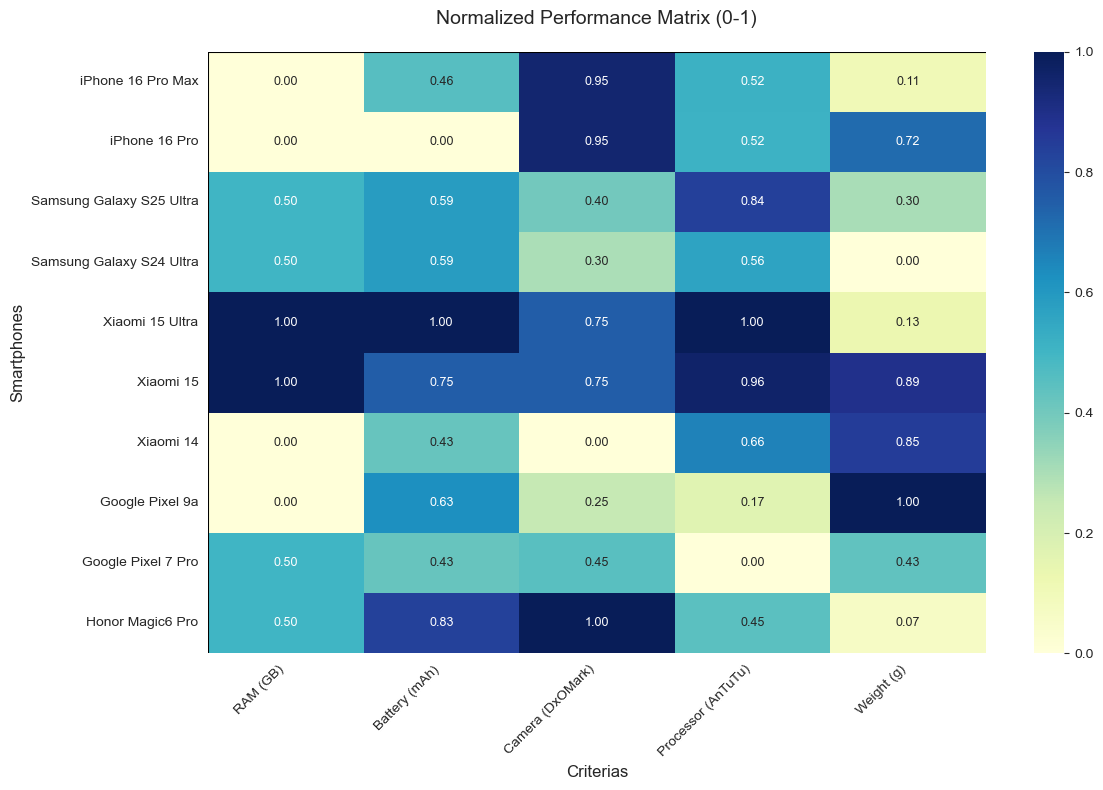

In [164]:
# Caricamento dati grezzi
df = pd.read_csv("../data/smartphones_raw.csv")
alternatives = df['Smartphone'].tolist()
raw_matrix = df.drop(columns='Smartphone').values

# Definizione scale RAW (basate sui dati)
scales = {
    'RAM (GB)': QuantitativeScale(8, 16, preference_direction=MAX),
    'Battery (mAh)': QuantitativeScale(3582, 6000, preference_direction=MAX),
    'Camera (DxOMark)': QuantitativeScale(138, 158, preference_direction=MAX),
    'Processor (AnTuTu)': QuantitativeScale(847016, 2459958, preference_direction=MAX),
    'Weight (g)': QuantitativeScale(186, 232, preference_direction=MIN)
}

plot_performance_matrix(raw_matrix)

## 2. Balanced user
### 2.1 Configuration

In [165]:
balanced_criteria = {
    'RAM (GB)': 0.15,
    'Battery (mAh)': 0.25,
    'Camera (DxOMark)': 0.25,
    'Processor (AnTuTu)': 0.25,
    'Weight (g)': 0.10
}

balanced_pt = PerformanceTable(
    raw_matrix,
    alternatives = alternatives,
    criteria = balanced_criteria,
    scales = scales
)

balanced_q = {
    'RAM (GB)': 2,
    'Battery (mAh)': 251,
    'Camera (DxOMark)': 2,
    'Processor (AnTuTu)': 200000,
    'Weight (g)': 5
}

balanced_p = {
    'RAM (GB)': 4,
    'Battery (mAh)': 502,
    'Camera (DxOMark)': 6,
    'Processor (AnTuTu)': 380000,
    'Weight (g)': 15
}

balanced_v = {
    'RAM (GB)': 4,
    'Battery (mAh)': 502,
    'Camera (DxOMark)': 12,
    'Processor (AnTuTu)': 700000,
    'Weight (g)': 30
}

### 2.2 Credibility Matrix

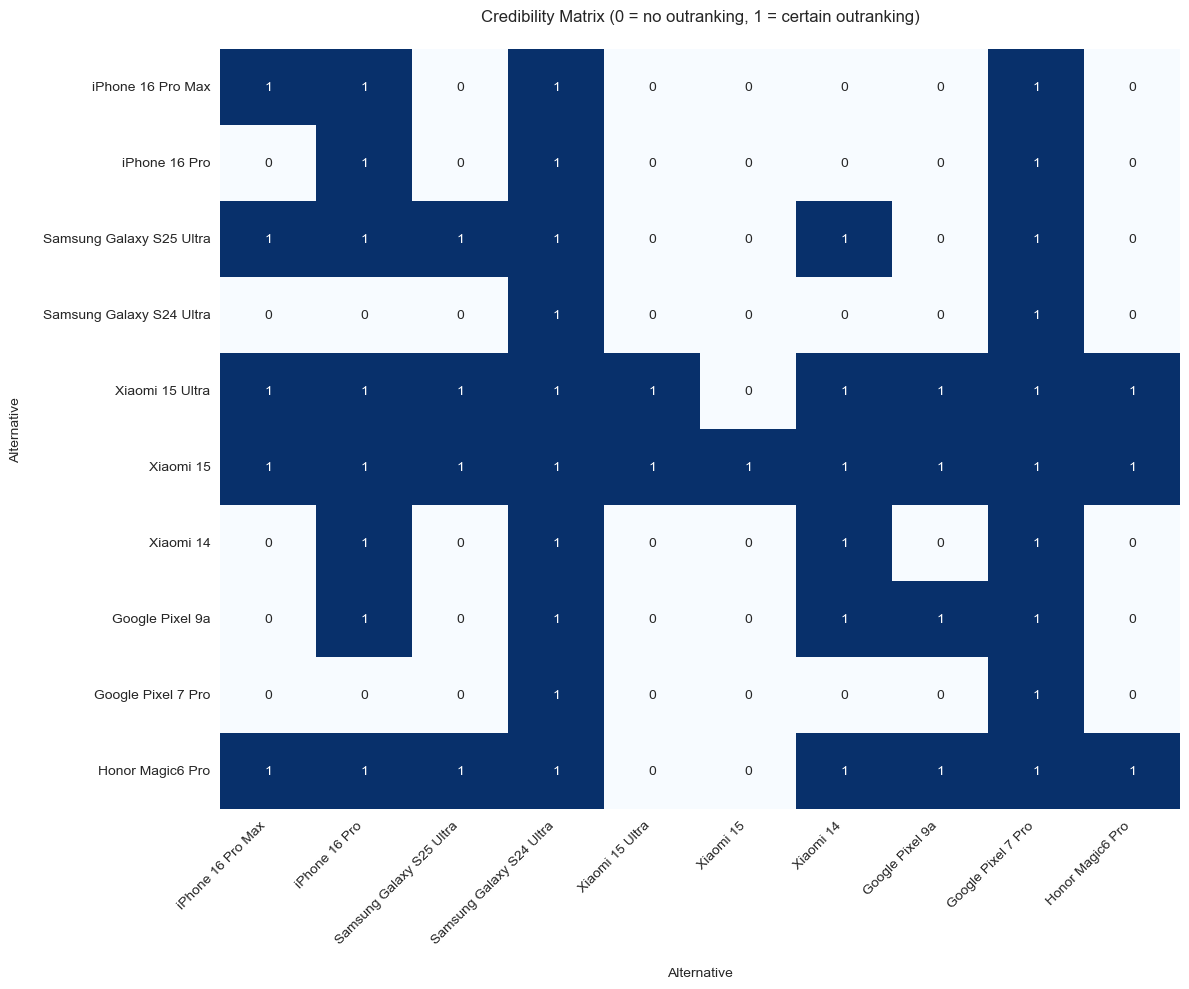

In [166]:
electre3 = Electre3(
    performance_table = balanced_pt,
    criteria_weights = balanced_criteria,
    preference_thresholds = balanced_p,
    indifference_thresholds = balanced_q,
    veto_thresholds = balanced_v,
    alpha = 0.3,
    beta = -0.15
)

balanced_rank = electre3.rank()

plot_credibility_matrix(balanced_rank)

### 2.3 Net Flow Scores

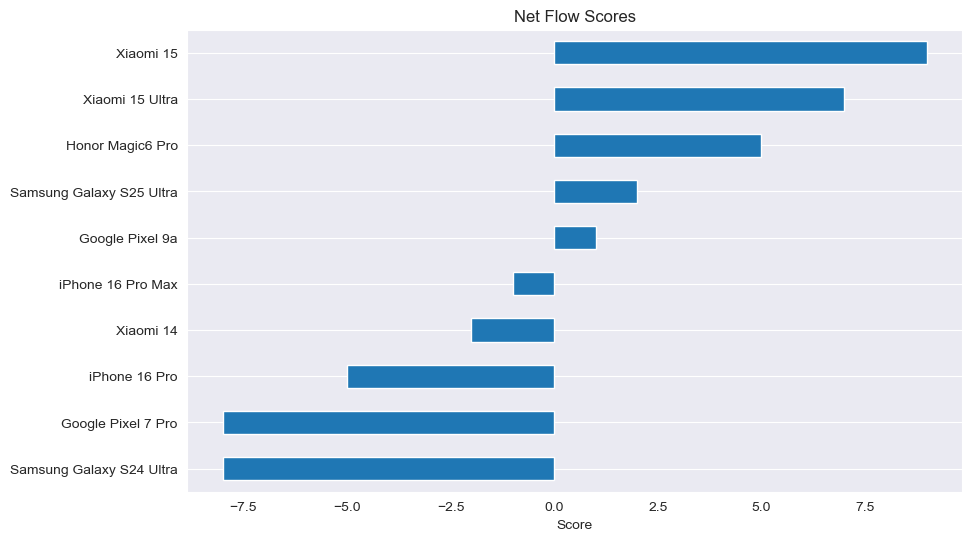

In [167]:
balanced_scores = balanced_rank.data.sum(axis=1) - balanced_rank.data.sum(axis=0)
plot_net_flow_scores(balanced_scores)

### 2.4 

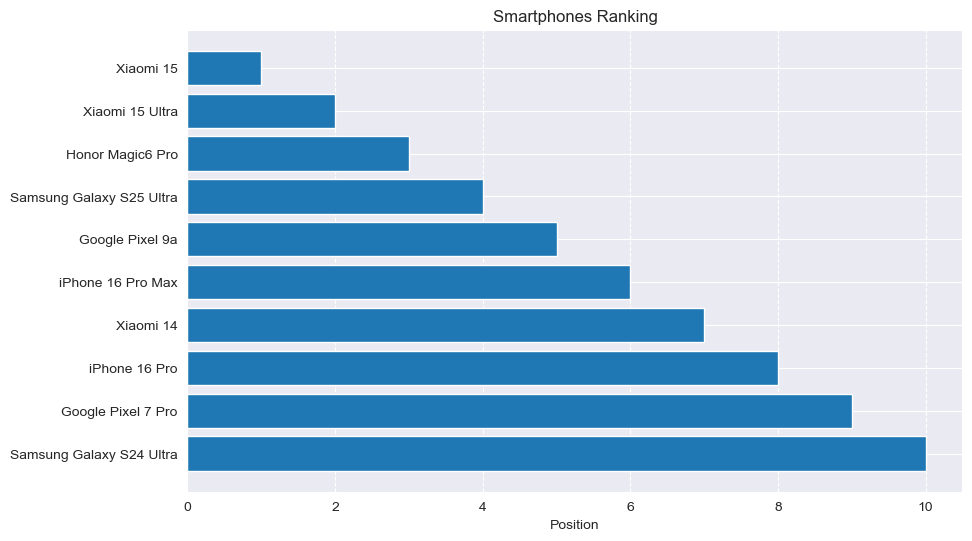

In [168]:
balanced_ranking = balanced_scores.sort_values(ascending=True).index.tolist()
plot_ranking_bars(balanced_ranking)

## 3. Performance user
### 3.1 Configuration

In [169]:
performance_criteria = {
    'RAM (GB)': 0.20,
    'Battery (mAh)': 0.05,
    'Camera (DxOMark)': 0.05,
    'Processor (AnTuTu)': 0.70,
    'Weight (g)': 0.0
}

performance_pt = PerformanceTable(
    raw_matrix,
    alternatives = alternatives,
    criteria = performance_criteria,
    scales = scales
)

performance_q = {
    'RAM (GB)': 1,
    'Battery (mAh)': 100,
    'Camera (DxOMark)': 1,
    'Processor (AnTuTu)': 50000, 
    'Weight (g)': 15
}

performance_p = {
    'RAM (GB)': 2,
    'Battery (mAh)': 400,
    'Camera (DxOMark)': 2,
    'Processor (AnTuTu)': 200000,
    'Weight (g)': 46
}

performance_v = {
    'RAM (GB)': 5,
    'Battery (mAh)': 700,
    'Camera (DxOMark)': 4,
    'Processor (AnTuTu)': 400000,
    'Weight (g)': 46
}

## 3.2

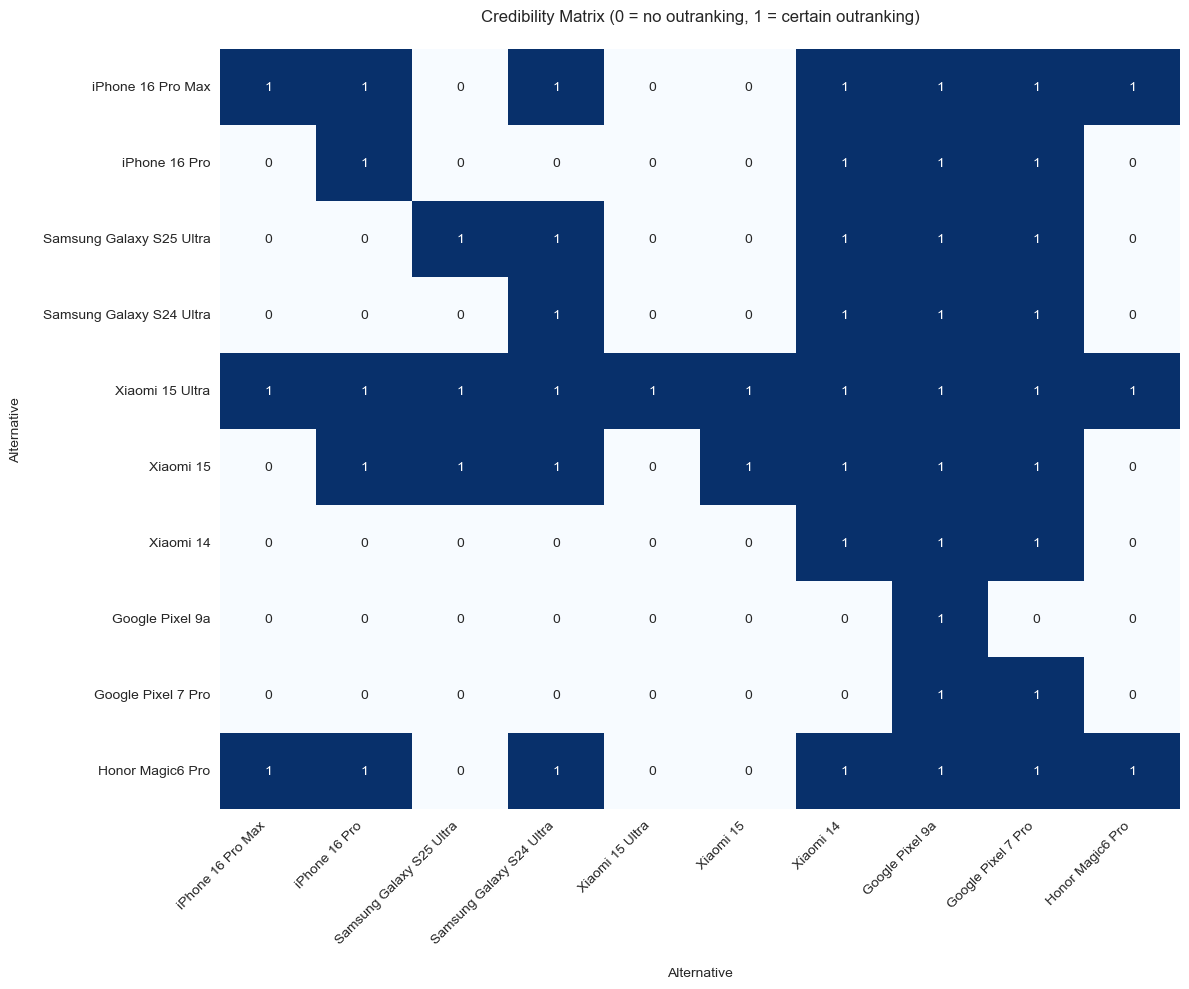

In [170]:
electre3 = Electre3(
    performance_table = performance_pt,
    criteria_weights = performance_criteria,
    preference_thresholds = performance_p,
    indifference_thresholds = performance_q,
    veto_thresholds = performance_v,
    alpha = 0.3,
    beta = -0.15
)

performance_rank = electre3.rank()

plot_credibility_matrix(performance_rank)

### 3.3 Net Flow Scores

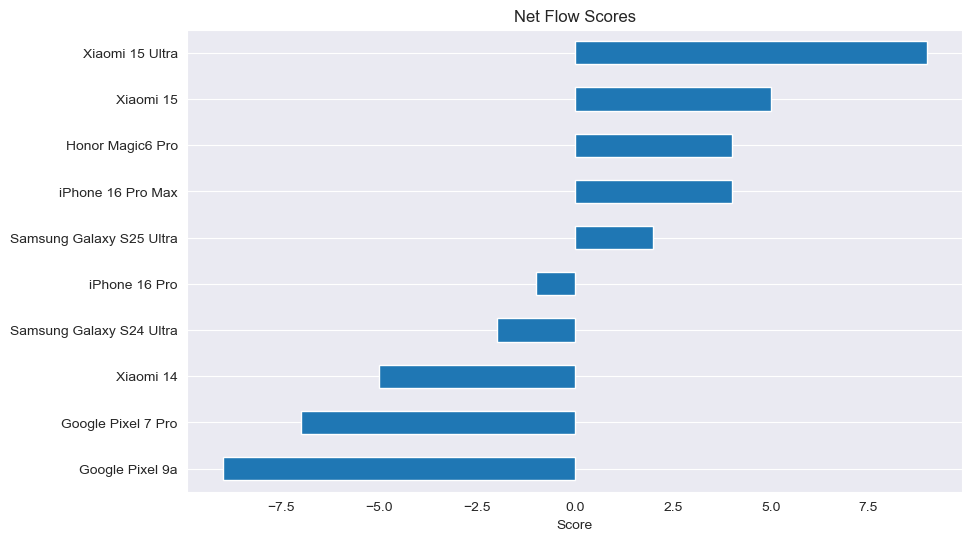

In [171]:
performance_scores = performance_rank.data.sum(axis=1) - performance_rank.data.sum(axis=0)
plot_net_flow_scores(performance_scores)

### 3.4 

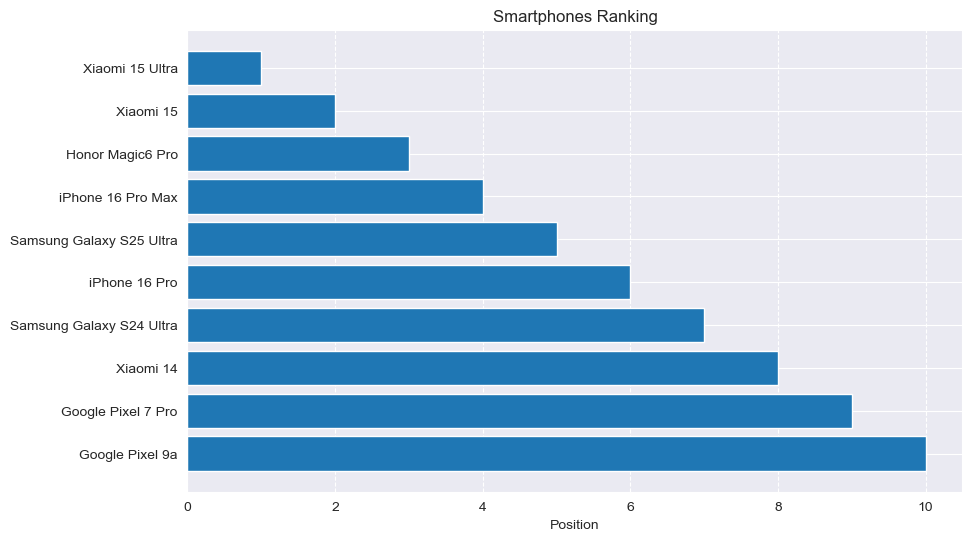

In [172]:
performance_ranking = performance_scores.sort_values(ascending=True).index.tolist()
plot_ranking_bars(performance_ranking)

## 4. Lightweight user
### 4.1 Configuration

In [173]:
lightweight_criteria = {
    'RAM (GB)': 0.0,
    'Battery (mAh)': 0.0,
    'Camera (DxOMark)': 0.0,
    'Processor (AnTuTu)': 0.0,
    'Weight (g)': 1.0
}

lightweight_pt = PerformanceTable(
    raw_matrix,
    alternatives = alternatives,
    criteria = lightweight_criteria,
    scales = scales
)

lightweight_q = {
    'RAM (GB)': 0,
    'Battery (mAh)': 0,
    'Camera (DxOMark)': 0,
    'Processor (AnTuTu)': 0,
    'Weight (g)': 5
}

lightweight_p = {
    'RAM (GB)': 0,
    'Battery (mAh)': 0,
    'Camera (DxOMark)': 0,
    'Processor (AnTuTu)': 0,
    'Weight (g)': 15
}

lightweight_v = {
    'RAM (GB)': 0,
    'Battery (mAh)': 0,
    'Camera (DxOMark)': 0,
    'Processor (AnTuTu)': 0,
    'Weight (g)': 20
}

### 4.2

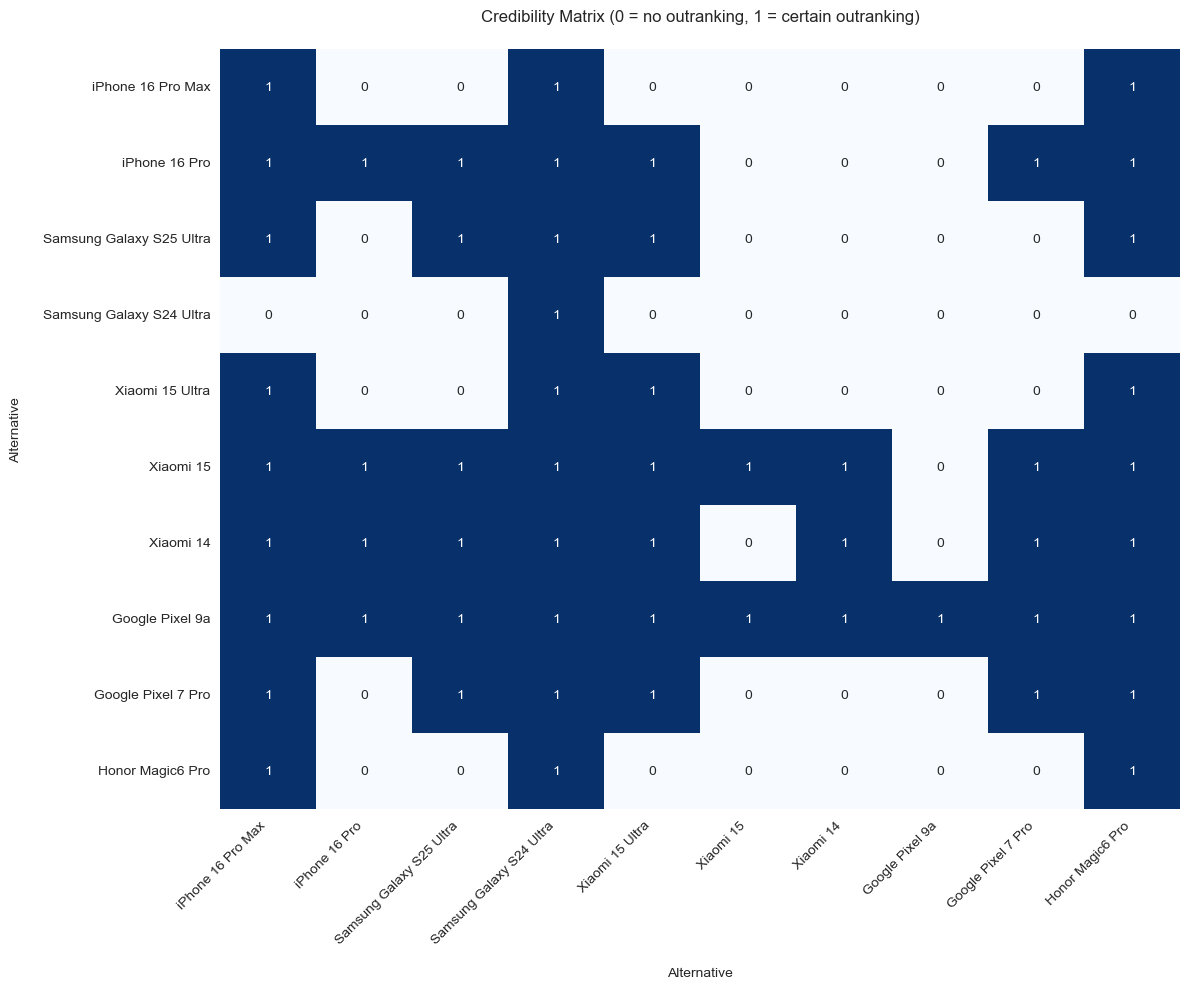

In [174]:
electre3 = Electre3(
    performance_table = lightweight_pt,
    criteria_weights = lightweight_criteria,
    preference_thresholds = lightweight_p,
    indifference_thresholds = lightweight_q,
    veto_thresholds = lightweight_v,
    alpha = 0.3,
    beta = -0.15
)

lightweight_rank = electre3.rank()
plot_credibility_matrix(lightweight_rank)

### 4.3 Net Flow Scores

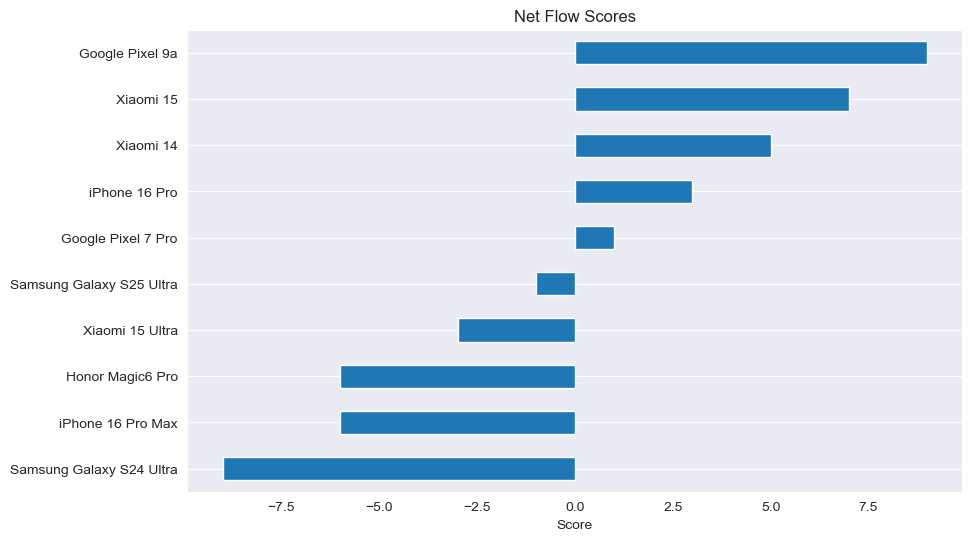

In [175]:
lightweight_scores = lightweight_rank.data.sum(axis=1) - lightweight_rank.data.sum(axis=0)
plot_net_flow_scores(lightweight_scores)

## 4.4

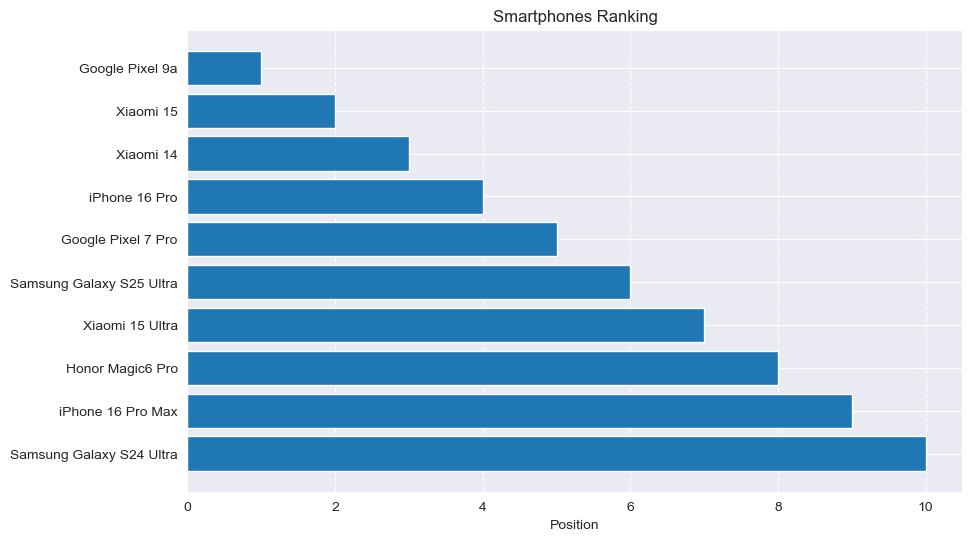

In [176]:
lightweight_ranking = lightweight_scores.sort_values(ascending=True).index.tolist()
plot_ranking_bars(lightweight_ranking)